<a href="https://colab.research.google.com/github/hahaslav/Labworks_SMAM_Lab_2/blob/main/%D0%86%D0%BC%D1%96%D1%82%D0%B0%D1%86%D1%96%D0%B9%D0%BD%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8E%D0%B2%D0%B0%D0%BD%D0%BD%D1%8F_%D0%B2_%D1%82%D0%B5%D0%BE%D1%80%D1%96%D1%97_%D0%B9%D0%BC%D0%BE%D0%B2%D1%96%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Робота №2

## Імітаційне моделювання в теорії ймовірності

Роботу виконала Бригада №1 у складі: Панчук Ігор(ком.), Шеметов Ярослав та Попович Марія.

#### Імпорт необхідних бібліотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

### 1. Моделювання вибірок

In [2]:
rand_exp = np.random.exponential(scale=1, size=100)
rand_norm = np.random.normal(loc=0, scale=2, size=1000)
rand_extrem = stats.genextreme.rvs(c=1, loc=0, scale=1, size=10000)

### 2. Перевірка належності до розподілів

#### 2.1) Критерій Колмогорова-Смирнова

In [3]:
# Estimate the lambda parameter for the exponential distribution
lambda_estimate = 1 / np.mean(rand_exp)

# Perform the K-S test against an exponential distribution with the estimated lambda
exp_ks_statistic, exp_p_value = stats.kstest(rand_exp, 'expon', args=(0, 1/lambda_estimate))

print(f"Exponential Distribution: KS Statistic = {exp_ks_statistic:f}, p-value = {exp_p_value:f}")

# Estimate the parameters for the normal distribution (mean and std)
mean_estimate = np.mean(rand_norm)
std_estimate = np.std(rand_norm)

# Perform the K-S test against a normal distribution with the estimated parameters
normal_ks_statistic, normal_p_value = stats.kstest(rand_norm, 'norm', args=(mean_estimate, std_estimate))

print(f"Normal Distribution: KS Statistic = {normal_ks_statistic:f}, p-value = {normal_p_value:f}")

shape, loc, scale = stats.genextreme.fit(rand_extrem)

# Perform the K-S test against the GEV distribution
extrem_ks_statistic, extrem_p_value = stats.kstest(rand_extrem, 'genextreme', args=(shape, loc, scale))

print(f"GEV Distribution: KS Statistic = {extrem_ks_statistic:f}, p-value = {extrem_p_value:f}")

Exponential Distribution: KS Statistic = 0.056870, p-value = 0.884370
Normal Distribution: KS Statistic = 0.029704, p-value = 0.334221
GEV Distribution: KS Statistic = 0.017168, p-value = 0.005442


#### 2.2) Критерій $\omega^2$

In [4]:
# Calculate the ECDF
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

exp_x, exp_ecdf_values = ecdf(rand_exp)
normal_x, normal_ecdf_values = ecdf(rand_norm)
extrem_x, extrem_ecdf_values = ecdf(rand_extrem)

# Estimate parameters of the distributions
# Exponential Distribution (estimate lambda)
lambda_exp = 1 / np.mean(rand_exp)

# Normal Distribution (estimate mean and std)
mu, std = np.mean(rand_norm), np.std(rand_norm)

# Extreme Value Distribution (Gumbel) parameters
params_extreme = stats.gumbel_r.fit(rand_extrem)

# Compute the theoretical CDFs for each distribution
# Exponential CDF
cdf_exp = stats.expon.cdf(exp_x, scale=1/lambda_exp)

# Normal CDF
cdf_normal = stats.norm.cdf(normal_x, loc=mu, scale=std)

# Extreme Value CDF
cdf_extreme = stats.gumbel_r.cdf(extrem_x, *params_extreme)

# Calculate the ω² statistic for each distribution
def omega_squared(ecdf_values, cdf_values):
    n = len(ecdf_values)
    omega2 = np.sum((cdf_values - (2 * np.arange(1, n + 1) - 1) / (2 * n))**2) + 1 / (12 * n)
    p_value = stats.kstwobign.sf(np.sqrt(n) * np.sqrt(omega2))
    return omega2, p_value

# Calculate ω² for each distribution
omega2_exp, o_p_exp = omega_squared(exp_ecdf_values, cdf_exp)
omega2_norm, o_p_norm = omega_squared(normal_ecdf_values, cdf_normal)
omega2_extrem, o_p_extrem = omega_squared(extrem_ecdf_values, cdf_extreme)

print(f"ω² for Exponential Distribution: {omega2_exp:f}, p-value: {o_p_exp}")
print(f"ω² for Normal Distribution: {omega2_norm:f}, p-value: {o_p_norm}")
print(f"ω² for Extreme Value Distribution: {omega2_extrem:f}, p-value: {o_p_extrem}")

ω² for Exponential Distribution: 0.043747, p-value: 0.0003171252864880548
ω² for Normal Distribution: 0.135476, p-value: 4.245728351036358e-118
ω² for Extreme Value Distribution: 189.912626, p-value: 0.0


#### 2.3) Критерій $\chi^2$

In [5]:
# Functions to perform chi-squared tests
def chi_squared_test(observed_freq, expected_freq):
    # Normalize the expected frequencies to match the sum of the observed frequencies
    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)
    return chi2_stat, p_value

def test_exponential_distribution(data):
    num_bins = 10
    observed_freq, bin_edges = np.histogram(data, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the exponential distribution to the data
    loc, scale = stats.expon.fit(data)

    # Calculate expected frequencies based on the fitted distribution
    expected_freq = np.diff(stats.expon.cdf(bin_edges, loc=loc, scale=scale)) * len(data)

    # Perform chi-squared test
    chi2_stat, p_value = chi_squared_test(observed_freq, expected_freq)
    print(f"Exponential Distribution: Chi2 Stat={chi2_stat:f}, p-value={p_value:f}")
    return p_value

def test_normal_distribution(data):
    num_bins = 10
    observed_freq, bin_edges = np.histogram(data, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the normal distribution to the data
    mu, std = stats.norm.fit(data)

    # Calculate expected frequencies based on the fitted distribution
    expected_freq = np.diff(stats.norm.cdf(bin_edges, loc=mu, scale=std)) * len(data)

    # Perform chi-squared test
    chi2_stat, p_value = chi_squared_test(observed_freq, expected_freq)
    print(f"Normal Distribution: Chi2 Stat={chi2_stat:f}, p-value={p_value:f}")
    return p_value

def test_extreme_value_distribution(data):
    num_bins = 10
    observed_freq, bin_edges = np.histogram(data, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the Gumbel (extreme value type 1) distribution to the data
    loc, scale = stats.gumbel_r.fit(data)

    # Calculate expected frequencies based on the fitted distribution
    expected_freq = np.diff(stats.gumbel_r.cdf(bin_edges, loc=loc, scale=scale)) * len(data)

    # Perform chi-squared test
    chi2_stat, p_value = chi_squared_test(observed_freq, expected_freq)
    print(f"Extreme Value Distribution: Chi2 Stat={chi2_stat:f}, p-value={p_value:f}")
    return p_value

# Run the tests
chi_exp = test_exponential_distribution(rand_exp)
chi_norm = test_normal_distribution(rand_norm)
chi_extrem = test_extreme_value_distribution(rand_extrem)

Exponential Distribution: Chi2 Stat=7.648392, p-value=0.569931
Normal Distribution: Chi2 Stat=5.528959, p-value=0.785978
Extreme Value Distribution: Chi2 Stat=596108844365225614425577812707925941321542024560640.000000, p-value=0.000000


### 3. Графічний аналіз гістограм та normal probability plot

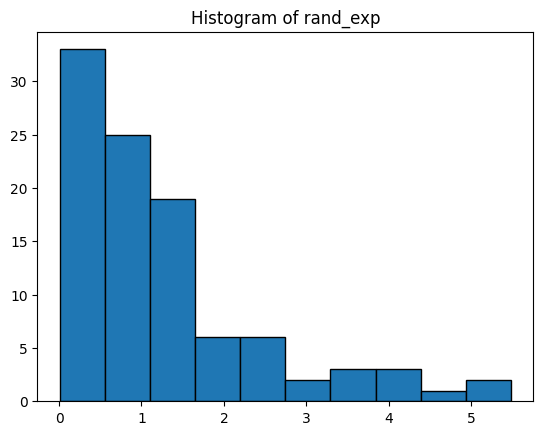

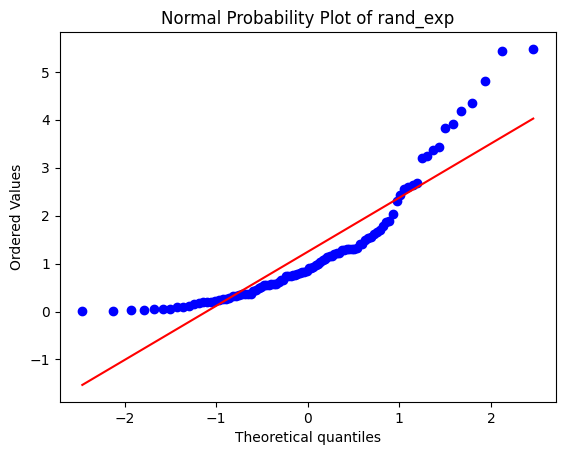

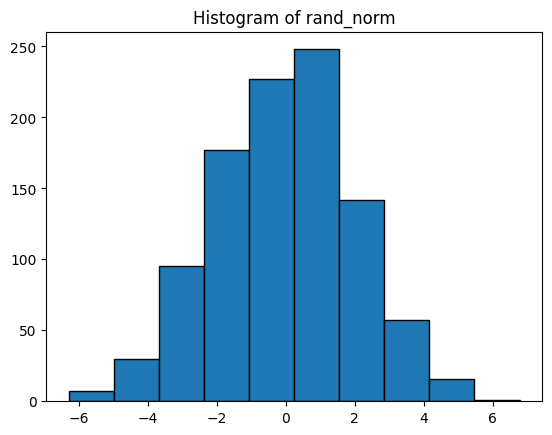

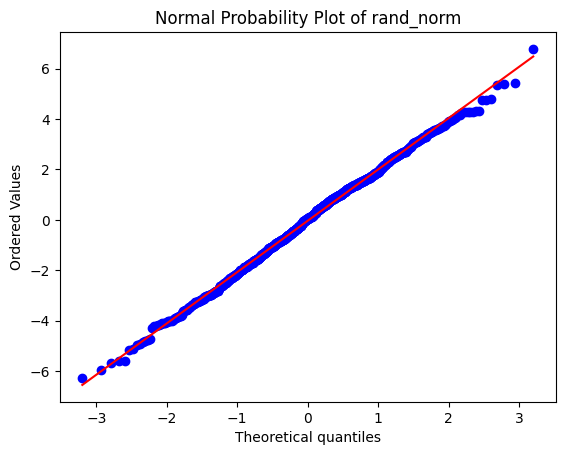

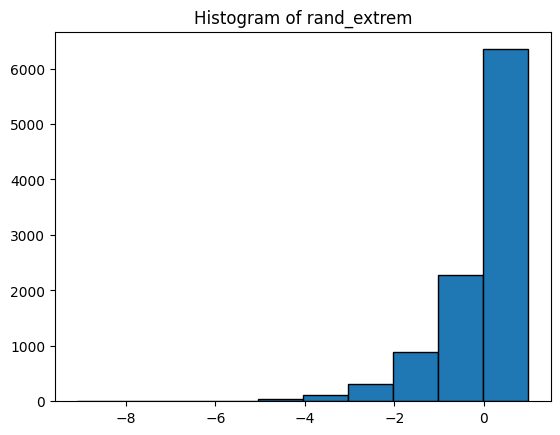

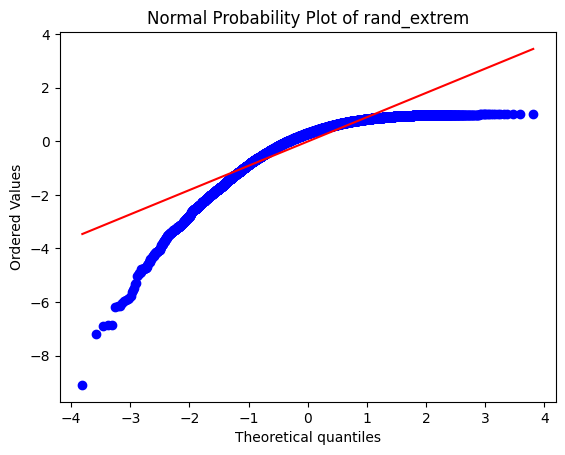

In [6]:
plt.hist(rand_exp, bins=10, edgecolor='black')
plt.title('Histogram of rand_exp')
plt.show()

stats.probplot(rand_exp, dist="norm", plot=plt)
plt.title('Normal Probability Plot of rand_exp')
plt.show()

plt.hist(rand_norm, bins=10, edgecolor='black')
plt.title('Histogram of rand_norm')
plt.show()

stats.probplot(rand_norm, dist="norm", plot=plt)
plt.title('Normal Probability Plot of rand_norm')
plt.show()

plt.hist(rand_extrem, bins=10, edgecolor='black')
plt.title('Histogram of rand_extrem')
plt.show()

stats.probplot(rand_extrem, dist="norm", plot=plt)
plt.title('Normal Probability Plot of rand_extrem')
plt.show()

### 4. Створення вибірки рівномірно розполідених чисел на (0, 1)

In [7]:
# np.random.rand() є аналогом СЛЧИС()/RAND() із Excel
rand_200 = np.random.rand(200)
rand_500 = np.random.rand(500)
rand_5000 = np.random.rand(5000)

### 5. Перевірка належності до розподілів

#### 5.1) Критерій Колмогорова-Смирнова

In [8]:
# Perform the Kolmogorov-Smirnov test
ks_statistic_200, ks_p_value_200 = stats.kstest(rand_200, 'uniform')
ks_statistic_500, ks_p_value_500 = stats.kstest(rand_500, 'uniform')
ks_statistic_5000, ks_p_value_5000 = stats.kstest(rand_5000, 'uniform')

print(f"n=200: KS Statistic: {ks_statistic_200:f}, P-value: {ks_p_value_200:f}")
print(f"n=500: KS Statistic: {ks_statistic_500:f}, P-value: {ks_p_value_500:f}")
print(f"n=5000: KS Statistic: {ks_statistic_5000:f}, P-value: {ks_p_value_5000:f}")

n=200: KS Statistic: 0.058274, P-value: 0.487397
n=500: KS Statistic: 0.035807, P-value: 0.531184
n=5000: KS Statistic: 0.010789, P-value: 0.601598


#### 5.2) Критерій $\omega^2$

In [9]:
def omega_squared_test(data):
    # Calculate the overall mean
    overall_mean = np.mean(data)

    # Calculate the group means and sizes
    group_means = np.array([np.mean(group) for group in data])
    group_sizes = np.array([len(group) for group in data])

    # Calculate the total sum of squares
    total_ss = np.sum([(x - overall_mean)**2 for group in data for x in group])

    # Calculate the between-groups sum of squares
    between_ss = np.sum(group_sizes * (group_means - overall_mean)**2)

    # Calculate omega-squared
    omega_squared = (between_ss - (len(data) - 1) * np.mean(group_sizes)) / (total_ss + np.mean(group_sizes))

    # Perform one-way ANOVA
    f_statistic, p_value = stats.f_oneway(*data)

    return omega_squared, f_statistic, p_value

omega_sq_200, f_stat_200, o_p_val_200 = omega_squared_test(np.array_split(rand_200[:198], 3))
omega_sq_500, f_stat_500, o_p_val_500 = omega_squared_test(np.array_split(rand_500[:498], 3))
omega_sq_5000, f_stat_5000, o_p_val_5000 = omega_squared_test(np.array_split(rand_5000[:4998], 3))

print(f"n=200: Omega-squared: {omega_sq_200:f}, F-statistic: {f_stat_200:f}, p-value: {o_p_val_200:f}")
print(f"n=500: Omega-squared: {omega_sq_500:f}, F-statistic: {f_stat_500:f}, p-value: {o_p_val_500:f}")
print(f"n=5000: Omega-squared: {omega_sq_5000:f}, F-statistic: {f_stat_5000:f}, p-value: {o_p_val_5000:f}")

n=200: Omega-squared: -1.606935, F-statistic: 0.794618, p-value: 0.453211
n=500: Omega-squared: -1.616472, F-statistic: 0.059200, p-value: 0.942525
n=5000: Omega-squared: -1.601337, F-statistic: 3.596815, p-value: 0.027482


#### 5.3) Критерій $\chi^2$

In [10]:
# Get the observed frequencies
observed_200 = np.unique(rand_200, return_counts=True)[1]
observed_500 = np.unique(rand_500, return_counts=True)[1]
observed_5000 = np.unique(rand_5000, return_counts=True)[1]

# Calculate the expected frequencies (assuming homogeneous distribution)
expected_200 = np.ones_like(observed_200) * np.mean(observed_200)
expected_500 = np.ones_like(observed_500) * np.mean(observed_500)
expected_5000 = np.ones_like(observed_5000) * np.mean(observed_5000)

# Perform chi-square test
chi2_statistic_200, c_p_value_200 = stats.chisquare(observed_200, expected_200)
chi2_statistic_500, c_p_value_500 = stats.chisquare(observed_500, expected_500)
chi2_statistic_5000, c_p_value_5000 = stats.chisquare(observed_5000, expected_5000)

print(f"n=200: Chi-square statistic: {chi2_statistic_200:f}, p-value: {c_p_value_200:f}")
print(f"n=500: Chi-square statistic: {chi2_statistic_500:f}, p-value: {c_p_value_500:f}")
print(f"n=5000: Chi-square statistic: {chi2_statistic_5000:f}, p-value: {c_p_value_5000:f}")

n=200: Chi-square statistic: 0.000000, p-value: 1.000000
n=500: Chi-square statistic: 0.000000, p-value: 1.000000
n=5000: Chi-square statistic: 0.000000, p-value: 1.000000


### 6. Представлення результатів у табличному вигляді

In [11]:
pd.DataFrame({
    "Перевірка": ["на експоненційний розподіл", "на нормальний розподіл", "на розподіл екстремальних значень", "на рівномірний розподіл", "на рівномірний розподіл", "на рівномірний розподіл"],
    "Вибірка": ["rand_exp", "rand_norm", "rand_extrem", "rand_200", "rand_500", "rand_5000"],
    "Критерій Колмогорова-Смирнова (p-value)": [exp_p_value, normal_p_value, extrem_p_value, ks_p_value_200, ks_p_value_500, ks_p_value_5000],
    "омега в квадраті (p-value)": [o_p_exp, o_p_norm, o_p_extrem, o_p_val_200, o_p_val_500, o_p_val_5000],
    "ксі в квадраті (p-value)": [chi_exp, chi_norm, chi_extrem, c_p_value_200, c_p_value_500, c_p_value_5000]})

,Перевірка,Вибірка,Критерій Колмогорова-Смирнова (p-value),омега в квадраті (p-value),ксі в квадраті (p-value)
0,на експоненційний розподіл,rand_exp,0.884370,3.171253e-04,0.569931
1,на нормальний розподіл,rand_norm,0.334221,4.245728e-118,0.785978
2,на розподіл екстремальних значень,rand_extrem,0.005442,0.000000e+00,0.000000
3,на рівномірний розподіл,rand_200,0.487397,4.532112e-01,1.000000
4,на рівномірний розподіл,rand_500,0.531184,9.425246e-01,1.000000
5,на рівномірний розподіл,rand_5000,0.601598,2.748190e-02,1.000000
